# Preprocessing

# New section

## Loading data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
train_x = np.load('train_data.npy')
train_y = np.load('train_label.npy')

test_x = np.load('test_data.npy')
test_y = np.load('test_label.npy')

In [ ]:
print('train_data：', train_x.dtype, train_x.shape)
print('train_label：', train_y.dtype, train_y.shape)
print('test_data：', test_x.dtype, test_x.shape)
print('test_label：', test_y.dtype, test_y.shape)

train_data： float64 (50000, 128)
train_label： uint8 (50000, 1)
test_data： float64 (10000, 128)
test_label： uint8 (10000, 1)


## Missing value checking

In [ ]:
def is_nan(data):
    has_nan = np.isnan(data).any()
    if has_nan:
        print("nan")
    else:
        print("no nan")

In [ ]:
is_nan(train_x)
is_nan(train_y)
is_nan(test_x)
is_nan(test_y)

no nan
no nan
no nan
no nan


## Normalization or standardization

### Min-max Normalization

In [ ]:
# Use the Min or Max value in training dataset to transform test dataset
class minmax:
    def fit(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def tran(self, data):
        return (data - self.min) / (self.max - self.min)

In [ ]:
minmax = minmax()
minmax_train_x = minmax.fit(train_x)
minmax_test_x = minmax.tran(test_x)

### Standardization

In [ ]:
# Use the Mean or Std value in training dataset to transform test dataset
class std:
  def fit(self, data):
      self.mean = data.mean(axis=0, keepdims=True)
      self.std = data.std(axis=0, keepdims=True)
      return (data - self.mean) / self.std

  def tran(self, data):
      return (data - self.mean) / self.std

In [ ]:
std = std()
standard_train_x = std.fit(train_x)
standard_test_x = std.tran(test_x)

# Multilayer Perceptron Framework

## Activation Class

**With GELU activation function**

In [ ]:
np.random.seed(seed=0)

In [ ]:
class Activation(object):
    def __relu(self, x):
        return np.maximum(0, x)

    def __relu_deriv(self, a):
        return np.where(a > 0, 1, 0) # np.where function, if true return 1 (first derivation of x), else return 0

    def __leaky_relu(self, x):
        return np.where(x > 0, x, x * 1e-2) # negative slope = 1e-2 default in PyTorch

    def __leaky_relu_deriv(self, a):
        return np.where(a > 0, 1, 1e-2) 

    # From paper "GAUSSIAN ERROR LINEAR UNITS(GELUS)"
    def __gelu(self, x):
        return 0.5*x*(1+np.tanh(np.sqrt(2/np.pi)*(x+0.044715*x**3))) #GELU(x) = 0.5x(1 + tanh[√2/π(x+ 0.044715x3)])

    def __gelu_deriv(self, a):
        x = np.sqrt(2/np.pi)*(a+0.044715*a**3)+0.5*a
        return 0.5 * (1 + np.tanh(x / np.sqrt(2)))

    # For the fully connected layer    
    def __NoneActivation(self, x):
        return x

    def __NoneActivation_deriv(self, a):
        return 1

    def __init__(self, activation=object):
        if activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'leaky_relu':
            self.f = self.__leaky_relu
            self.f_deriv = self.__leaky_relu_deriv
        elif activation == 'gelu':
            self.f = self.__gelu
            self.f_deriv = self.__gelu_deriv
        else:
            self.f = self.__NoneActivation
            self.f_deriv = self.__NoneActivation_deriv

## Hidden Layer Structure

In [ ]:
class HiddenLayer(object):    
    def __init__(self,n_in, n_out, layer_index, activation=None, dropout_rate=0, bn = True, fully_layer = False): ############################in this step, BNBNBNBNBNBBNBNBNBNBNBBNB
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is user defined

        Hidden unit activation is given by: relu(dot(input,W) + b) etc.

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden layer
        
        :type dropout_rate: float
        :param dropout_rate: Probability of dropping out a neuron during training
        """

        self.input=None
        self.n_in = n_in
        self.n_out = n_out
        self.activation=activation # --> self.__xxx in Activation Class
        self.dropout_rate = dropout_rate
        self.bn = bn
        self.fully_layer = fully_layer
        self.name = "Hidden layer " + str(layer_index + 1) if not self.fully_layer else "Fully connected layer"

        # using Kaiming initialization
        # From paper "Delving Deep into Rectifiers:Surpassing Human-Level Performance on ImageNet Classification"
        print(activation)
        if activation == 'relu':
            std = np.sqrt(2.0 / n_in)
            self.W = np.random.normal(0, std, size=(n_in, n_out))  # Kaiming normal --> N(0, 2/n)
        # Kaiming initialization for Leaky ReLU
        elif activation == 'leaky_relu':
            a = 0.01 # Using slope rate here
            std = np.sqrt(2.0 / ((1+a**2)*n_in)) # Kaiming normal for PRelu--> N(0, 2/(1+a^2)n)
            self.W = np.random.normal(0, std, size=(n_in, n_out))
        # According to paper "ADJUSTING FOR DROPOUT VARIANCE IN BATCH NORMALIZATION AND WEIGHT INITIALIZATION"
        elif activation == 'gelu':
            self.W = np.random.normal(size=(n_in, n_out))
            self.W /= np.linalg.norm(self.W, axis=0, keepdims=True)
        # Random initialization for other activation functions
        else:
            self.W = np.random.uniform(
                    low=-np.sqrt(6. / (n_in + n_out)),
                    high=np.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
            )

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set he size of weight gradation as the size of weight
        # the following are the accumulate gradient w.r.t. W and b
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        # momentum
        self.V_w = np.zeros(self.W.shape)
        self.V_b = np.zeros(self.b.shape)

        # Adam
        # first moment
        self.m_w = np.zeros(self.W.shape)       
        self.m_b = np.zeros(self.b.shape)
        # second moment
        self.v_w = np.zeros(self.W.shape)
        self.v_b = np.zeros(self.b.shape)


         # batch normalization init
        self.bn_cache = {}
        self.bn_eval = {"running_mean": np.zeros(n_out),
                        "running_var": np.zeros(n_out)}
        self.bn_param = {
            "eps": 1e-5,
            "momentum": 0.1,
            "gamma": np.ones(self.n_out, ),
            "beta": np.zeros(self.n_out, )
        }
        
    
    # the forward and backward progress (in the hidden layer level) for each training epoch
    def forward(self, input, mode):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        :type train: bool
        :param train: Whether the network is in training mode or not
        '''
        self.bs = input.shape[0]
        self.input = input
        self.mode = mode

        # linear transformation
        self.lin_output = np.dot(input, self.W) + self.b 

        act = Activation(self.activation).f

        # fully connected layer
        if self.fully_layer:
            self.activation_output = act(self.lin_output)
            return self.activation_output

        # Batch normalization
        self.bn_output = self.bn_forward(self.lin_output)

        # Dropout
        if self.mode == 'train' and self.dropout_rate > 0:
            # Apply dropout to the layer's output during training
            dropout_mask = np.random.binomial(1, 1 - self.dropout_rate, size=(self.bs, self.n_out)) # Mask return a matrix consists of 0, 1 with the same shape as output
            self.dropout_output = self.lin_output * dropout_mask / (1 - self.dropout_rate) # Scaled up by (1-dp) to ensure the consistency of Expectation between training and test

        # No dropout
        else:
            self.dropout_output = (
                self.lin_output if self.activation is None
                else act(self.lin_output)
            )
        
        # Activation
        self.activation_output = act(self.dropout_output)

        return self.activation_output
    
    def backward(self, delta):    # delta is the calculated gradient, i.e., -error*activation_deriv(y_hat) 
        activation_deriv=Activation(self.activation).f_deriv 
        if not self.fully_layer:
            delta = activation_deriv(delta)
            #Scaled in forward, needn't dropout here
            delta = self.bn_backward(delta)

        # the gradient of the loss with respect to the weights
        grad_W_sum = []
        for i in range(self.bs):
            grad_W_sum.append(np.atleast_2d(self.input[i]).T.dot(np.atleast_2d(delta[i]))) #.atleast_2d make sure both of them are 2 dimensional array
        grad_W_sum = np.stack(grad_W_sum, axis=0)
        
        # the gradient of the loss with respect to the bias
        self.grad_b = delta

        # set grad_W to 0                           
        self.grad_W = np.mean(grad_W_sum, axis=0)
        self.grad_b = np.mean(delta, axis=0)

        delta = delta.dot(self.W.T) # get the gradient
        
        return delta
    # Forward functions for minibatch
    def bn_forward(self, input):
        if self.bn:
            eps = self.bn_param["eps"]
            momentum = self.bn_param['momentum']
            if self.mode == 'train':
                batch_mean = np.mean(input, axis=0)
                batch_var = np.var(input, axis=0)
                # Estimate running average of mean and variance to use at test time
                self.bn_eval['running_mean'] = momentum * self.bn_eval['running_mean'] + (1 - momentum) * batch_mean
                self.bn_eval['running_var'] = momentum * self.bn_eval['running_var'] + (1 - momentum) * batch_var
                # Normalization followed by Affine transformation
                input_norm = (input - batch_mean) / np.sqrt(batch_var + eps)
                output = self.bn_param["gamma"] * input_norm + self.bn_param["beta"]
                # Cache variables needed during backpropagation
                self.bn_cache["input"] = input
                self.bn_cache["input_norm"] = input_norm
                self.bn_cache["batch_mean"] = batch_mean
                self.bn_cache["batch_var"] = batch_var
                self.bn_cache["gamma"] = self.bn_param["gamma"]
                self.bn_cache["beta"] = self.bn_param["beta"]
                self.bn_cache["eps"] = self.bn_param['eps']
            elif self.mode == 'eval':
                # normalize using running average
                test_bn_mean = self.bn_eval["running_mean"]
                test_bn_var = (self.bn_eval["running_var"].shape[0])/((self.bn_eval["running_var"].shape[0])-1)*self.bn_eval["running_var"] # Unbiased estimation
                input_norm = (input - test_bn_mean) / np.sqrt(test_bn_var + eps)
                # output = self.bn_param["gamma"] * input_norm + self.bn_param["beta"]
                output = self.bn_param["gamma"]/np.sqrt(test_bn_var+eps)* input_norm + (self.bn_param["beta"] - (self.bn_param["gamma"]*test_bn_mean)/np.sqrt(test_bn_var+eps))
            return output
        else:
            return input

    # Backward functions for minibatch
    def bn_backward(self, delta):
        if self.bn:
            # Unpack parameters
            input_norm = self.bn_cache["input_norm"]
            batch_var = self.bn_cache["batch_var"]
            eps = self.bn_cache["eps"]
            input = self.bn_cache["input"]
            batch_mean = self.bn_cache["batch_mean"]
            gamma = self.bn_cache["gamma"]
            # See derivations above for dgamma, dbeta and dx
            self.bn_param["dgamma"] = np.sum(delta * input_norm, axis=0)
            self.bn_param["dbeta"] = np.sum(delta, axis=0)           
            m = input.shape[0]
            t = 1. / np.sqrt(batch_var + eps)
            # Calculate the derivations
            delta = (gamma * t / m) * (m * delta - np.sum(delta, axis=0)
                                       - t ** 2 * (input - batch_mean)
                                       * np.sum(delta * (input - batch_mean), axis=0))

        return delta


## Optimizer

SGD_momentum & **Adam** optimizer

In [ ]:
class SGD_Momentum:
    def step(self, model, lr, momentum=0.1, weight_decay=0):
        for layer in model.layers:
            # Update momentum paramters
            layer.V_w = momentum * layer.V_w + lr * layer.grad_W + lr * weight_decay * layer.W
            layer.V_b = momentum * layer.V_b + lr * layer.grad_b

            # Update Weight
            layer.W = layer.W - layer.V_w

            # Update Bias
            layer.b = layer.b - layer.V_b

            # Update parameters in BN
            if layer.bn and not layer.fully_layer:
                layer.bn_param['gamma'] = layer.bn_param['gamma'] - lr * layer.bn_param['dgamma']
                layer.bn_param['beta'] = layer.bn_param['beta'] - lr * layer.bn_param['dbeta']

class Adam:
    def __init__(self):
        self.t = 0

    def step(self, model, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        Layer by layer back propagation with batch normalization.

        :type model: MLP
        :param model: the model to be updated

        :type lr: float
        :param lr: the rate to update parameters

        :type beta1: float
        :param beta1: first moment coefficient

        :type beta2: float
        :param beta2: second moment coefficient

        :type epsilon: float
        :param epsilon: small constant to avoid division by zero
        """
        self.t += 1
        for layer in model.layers:
            # Update first and second moments for weights
            layer.m_w=beta1*layer.m_w+(1-beta1)*layer.grad_W
            layer.v_w=beta2*layer.v_w+(1-beta2)*(layer.grad_W**2)

            # Bias-corrected first and second moments for weights
            m_w_hat=layer.m_w/(1-beta1**self.t)
            v_w_hat=layer.v_w/(1-beta2**self.t)

            # Update weights
            layer.W=layer.W-lr*m_w_hat/(np.sqrt(v_w_hat) + epsilon)

            # Weight decay
            weight_decay: float = 0.00005
            layer.W=layer.W-layer.W*weight_decay

            # Update first and second moments for biases
            layer.m_b=beta1*layer.m_b+(1-beta1)*layer.grad_b
            layer.v_b=beta2*layer.v_b+(1-beta2)*(layer.grad_b**2)

            # Bias-corrected first and second moments for biases
            m_b_hat=layer.m_b/(1-beta1**self.t)
            v_b_hat=layer.v_b/(1-beta2**self.t)

            # Update biases
            layer.b=layer.b-lr*m_b_hat/(np.sqrt(v_b_hat)+epsilon)

            # Reset gradients
            layer.grad_W=np.zeros_like(layer.grad_W)
            layer.grad_b=np.zeros_like(layer.grad_b)

            # Update parameters in BN
            if layer.bn and not layer.fully_layer:
                layer.bn_param['gamma'] = layer.bn_param['gamma'] - lr * layer.bn_param['dgamma']
                layer.bn_param['beta'] = layer.bn_param['beta'] - lr * layer.bn_param['dbeta']


## MLP Structure

In [ ]:
class MLP:

    # for initialization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, neurons=[128, 256, 10], activation=[None,'relu','relu'], optimizer=None, dropout=0.5, bn=True):      
        self.neurons = neurons
        self.bn = bn
        self.activation = activation
        self.dropout = dropout
        self.optimizer = optimizer
        
        # We set the default mode as train
        self.mode = 'train'
        self.layers = []
        for i in range(len(neurons) - 1):
            # add layers
            self.layers.append(HiddenLayer(n_in=neurons[i], # input size
                                         n_out=neurons[i + 1], # output size
                                         activation=self.activation[i + 1], # the inner activation layer of this layer
                                         layer_index=i, # layer index
                                         bn=self.bn, # batch normalisation switch
                                         dropout_rate=self.dropout, # dropout rate
                                         fully_layer=(i == len(neurons) - 2))) # flag of output_layer, -2 because of range() function
    # Training process
    def train(self):
        self.mode = 'train'
    # Test process
    def eval(self):
        self.mode = 'eval'
    
    # Forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input, self.mode)
            input=output
        return output

    # Backward progress  
    def backward(self,delta):
        for layer in reversed(self.layers):
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!    
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    def accuracy(self, y, y_hat):
        y_pred = np.argmax(y_hat, axis=1).reshape(y.shape)
        accuracy = np.equal(y, y_pred).sum() / y.shape[0]
        return accuracy

    # define the prediction function
    def predict(self, X):
        y_hat = self.forward(X)
        y_pred = np.argmax(y_hat, axis=1)
        return y_pred

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self, X, y, bs=8, learning_rate=0.1, epochs=100, momentum=0.9, weight_decay=0, beta1=0.9, beta2=0.999, epsilon=1e-8, data_val="data_test", label_val="label_test"):
        # Show the parameters of model
        print("___________")
        print("Model details: ")
        print('Model layers: {}// Model activation functions: {}//  Optimizer: {}//  Batch size: {}//  Total epoch: {}//  Learning rate: {}//  Dropout: {}//  Batch Norm: {}'.format(
                    self.neurons,
                    self.activation,
                    self.optimizer,
                    bs,
                    epochs,
                    learning_rate,
                    self.dropout,
                    self.bn
                    )) # +++++++++++++++++++++++++++++++++++Runing time
        print("SGD Momentum Parameters: ")
        print('Momentum: {}  Weight decay: {}'.format(
                    momentum,
                    weight_decay))
        print("Adam Parameters: ")
        print('beta1: {}  beta2: {} epsilon: {}'.format(
                    beta1,
                    beta2,
                    epsilon))
        print("___________")

        X=np.array(X)
        y=np.array(y)

        # Training process
        self.train() 
        training_accuracies = []
        validation_accuracies = []
        training_losses = []
        validation_losses = []

        for k in range(epochs):
          
            start = time.time()
            # Shuffling every epoch
            index = np.arange(X.shape[0])
            np.random.shuffle(index)
            train_X = X[index]
            train_y = y[index]

            loss_sum = 0
            for start_index in range(0, train_X.shape[0], bs): # Select mini-batch from training data
                X_minibatch = train_X[start_index:min(start_index+bs, train_X.shape[0])] # To avoid getting none value
                if len(X_minibatch) < bs: # drop data that may not have the amount of a batch
                    break
                y_minibatch = train_y[start_index:min(start_index+bs, train_y.shape[0])]
                # forward pass
                y_hat = self.forward(X_minibatch)
                
                # backward pass
                loss, delta = CrossEntropy().criterion_CrossEntropy(y_minibatch, y_hat)
                self.backward(delta)
                if self.optimizer == 'SGD_momentum':
                    optim = SGD_Momentum()
                    optim.step(self, learning_rate, momentum=momentum, weight_decay=weight_decay)
                elif self.optimizer == 'Adam':
                    optim = Adam()
                    optim.step(self, learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
                else:
                    return "No Supported Optimizer!"
                
                # Loss summation for one epoch
                # Epoch loss sum
                loss_sum += loss.sum()

            # Evaluation process
            self.eval()
            y_hat_train = self.forward(train_X)
            y_hat_val = self.forward(data_val)
            training_acc = self.accuracy(train_y, y_hat_train)
            val_acc = self.accuracy(label_val, y_hat_val)
            loss_val, _ = CrossEntropy().criterion_CrossEntropy(label_val, y_hat_val)
            
            training_accuracies.append(training_acc)
            validation_accuracies.append(val_acc)
            training_losses.append(loss_sum/len(train_X))
            validation_losses.append(loss_val/len(data_val))
            
            end = time.time()
            # Print evaluation result
            print(
                'Epoch ({}/{}): Train Loss: {}  Train Accuracy: {}  Validation Loss: {}  Validation Accuracy: {}'.format(
                    k + 1,
                    epochs,
                    loss_sum/len(train_X),
                    training_acc,
                    loss_val/len(data_val),
                    val_acc)) # +++++++++++++++++++++++++++++++++++Runing time
            print(f"Runtime of the epoch {k+1} is {end - start} s")

        return self, training_accuracies, validation_accuracies, training_losses, validation_losses

### CrossEntropy

In [ ]:
class CrossEntropy(object):
    def __init__(self):
        self.name = "CrossEntropy Loss layer"

    def oneHotEncoding(self, data, n_class):
        onehot = np.zeros((data.shape[0], n_class))
        for i in range(data.shape[0]):
            k = int(data[i])
            onehot[i, k] = int(1)
        return onehot.squeeze()

    def softmax(self, data):
        output = []
        for i in range(0, data.shape[0]):
            equ = np.exp(data[i]) / np.exp(data[i]).sum()
            output.append(equ)
        return np.vstack(output)

    def criterion_CrossEntropy(self, y, y_hat):
        n_class = y_hat.shape[-1]
        y_hat_prob = self.softmax(y_hat)
        y_one_hot = np.array(self.oneHotEncoding(y, n_class))
        eps = np.finfo(float).eps  # in case of infinite log
        loss = -np.sum(y_one_hot * np.log(y_hat_prob + eps))
        delta = y_hat_prob - y_one_hot
        return loss, delta

# Training Process & Test

In [ ]:
# number of classes
n_class = np.unique(train_y).shape[0]
# number of features
n_features = train_x.shape[1]

In [ ]:
data_train = train_x
data_test = test_x
label_train = train_y
label_test = test_y

# Our Best Module

In [ ]:
nn_best = MLP([n_features,512,n_class],[None,'leaky_relu','leaky_relu',None], optimizer='Adam',dropout=0,bn=True)

leaky_relu
leaky_relu


In [ ]:
model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn_best.fit(data_train,
                                                                                              label_train, 
                                                                                              learning_rate=0.001, 
                                                                                              epochs=25, 
                                                                                              bs=64,
                                                                                              data_val=data_test, 
                                                                                              label_val=label_test, 
                                                                                              momentum=0,
                                                                                              weight_decay=0.01)                                                                          

___________
Model details: 
Model layers: [128, 512, 10]// Model activation functions: [None, 'leaky_relu', 'leaky_relu', None]//  Optimizer: Adam//  Batch size: 64//  Total epoch: 25//  Learning rate: 0.001//  Dropout: 0//  Batch Norm: True
SGD Momentum Parameters: 
Momentum: 0  Weight decay: 0.01
Adam Parameters: 
beta1: 0.9  beta2: 0.999 epsilon: 1e-08
___________
Epoch (1/25): Train Loss: 1.8049960226091726  Train Accuracy: 0.42616  Validation Loss: 1.6948894410927868  Validation Accuracy: 0.416
Runtime of the epoch 1 is 43.75105619430542 s
Epoch (2/25): Train Loss: 1.6884643502523025  Train Accuracy: 0.43244  Validation Loss: 1.6664980619613912  Validation Accuracy: 0.4235
Runtime of the epoch 2 is 50.940065145492554 s
Epoch (3/25): Train Loss: 1.657774198186596  Train Accuracy: 0.43916  Validation Loss: 1.6421071071261402  Validation Accuracy: 0.4313
Runtime of the epoch 3 is 47.11517095565796 s
Epoch (4/25): Train Loss: 1.6434793198598305  Train Accuracy: 0.4366  Validation Loss

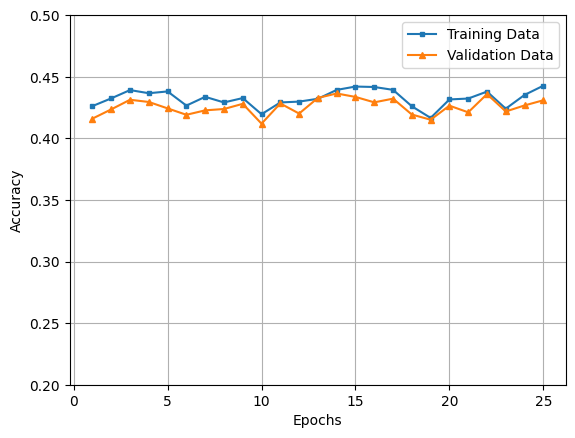

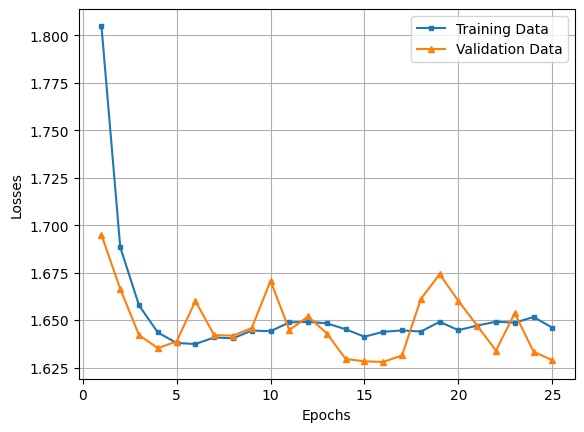

In [ ]:
# Plot the accuracy curves
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Data', markersize=5, marker = '^')
plt.ylim(0.2,0.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()
#plt.savefig('./Accuracy curves.jpg')

# Plot the loss curves
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid()
plt.legend()
plt.show()
#plt.savefig('./Loss curves.jpg')

 # Neural structure comparison **[Note: The following code is the comparison experiments that may cost lots of running time]------------------------------------------------------------**

### Baseline Model

In [ ]:
nn = MLP([n_features, 128, 128, n_class], [None, 'relu', 'relu', None], optimizer = 'Adam', dropout=0, bn=True)

In [ ]:
# Start training and store the accuracies
baseline_training_accuracies = []
baseline_validation_accuracies = []
baseline_training_losses = []
baseline_validation_losses = []

model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn.fit(data_train,
                                                                                              label_train, 
                                                                                              learning_rate=0.0001, 
                                                                                              epochs=25, 
                                                                                              bs=64,
                                                                                              data_val=data_test, 
                                                                                              label_val=label_test, 
                                                                                              momentum=0.9,
                                                                                              weight_decay=False)

baseline_training_accuracies.append(training_accuracies)
baseline_validation_accuracies.append(validation_accuracies)
baseline_training_losses.append(training_losses)
baseline_validation_losses.append(validation_losses)

In [ ]:
# Plot the accuracy curves
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.savefig('./Baseline_Model_Accuracy_Curves.jpg')

# Plot the loss curves
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid()
plt.legend()

plt.savefig('./Baseline_Model_Loss_Curves.jpg')

## Compare hidden layer number

### 1 hidden layer, 256 neurons, Relu, Adam, no dropout, bn = True

In [ ]:
nn11 = MLP([n_features, 128, 128, n_class], [None, 'relu', 'relu', None], optimizer = 'Adam', dropout=0, bn=True)

In [ ]:
# Start training and store the accuracies
baseline_training_accuracies = []
baseline_validation_accuracies = []
baseline_training_losses = []
baseline_validation_losses = []
model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn11.fit(data_train,
                                                                                              label_train, 
                                                                                              learning_rate=0.0001, 
                                                                                              epochs=25, 
                                                                                              bs=64,
                                                                                              data_val=data_test, 
                                                                                              label_val=label_test, 
                                                                                              momentum=0.9,
                                                                                              weight_decay=False)
baseline_training_accuracies.append(training_accuracies)
baseline_validation_accuracies.append(validation_accuracies)
baseline_training_losses.append(training_losses)
baseline_validation_losses.append(validation_losses)

In [ ]:
# Plot the accuracy curves
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()
#plt.savefig('./Accuracy curves.jpg')

# Plot the loss curves
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid()
plt.legend()
plt.show()
#plt.savefig('./Loss curves.jpg')

In [ ]:
nn22 = MLP([n_features, 128, 128, n_class], [None, 'leaky_relu', 'leaky_relu', None], optimizer = 'Adam', dropout=0, bn=True)

In [ ]:
# Start training and store the accuracies
training_accuracies_43 = []
validation_accuracies_43 = []
training_losses_43 = []
validation_losses_43 = []
model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn22.fit(data_train,
                                                                                              label_train, 
                                                                                              learning_rate=0.0001, 
                                                                                              epochs=25, 
                                                                                              bs=64,
                                                                                              data_val=data_test, 
                                                                                              label_val=label_test, 
                                                                                              momentum=0.9,
                                                                                              weight_decay=False)
training_accuracies_43.append(training_accuracies)
validation_accuracies_43.append(validation_accuracies)
training_losses_43.append(training_losses)
validation_losses_43.append(validation_losses)

### 2 hidden layers, 256 & 256 neurons, Relu, Adam, no dropout, bn = True

In [ ]:
nn = MLP([n_features, 128, 128, n_class], [None, 'gelu', 'gelu', None], optimizer = 'Adam', dropout=0, bn=True)

In [ ]:
# Start training and store the accuracies
training_accuracies_42 = []
validation_accuracies_42 = []
training_losses_42 = []
validation_losses_42 = []

model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn.fit(data_train,
                                                                                              label_train, 
                                                                                              learning_rate=0.0001, 
                                                                                              epochs=25, 
                                                                                              bs=64,
                                                                                              data_val=data_test, 
                                                                                              label_val=label_test, 
                                                                                              momentum=0.9,
                                                                                              weight_decay=False)
training_accuracies_42.append(training_accuracies)
validation_accuracies_42.append(validation_accuracies)
training_losses_42.append(training_losses)
validation_losses_42.append(validation_losses)

In [ ]:
# Plot the accuracy curves
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()
#plt.savefig('./Accuracy curves.jpg')

# Plot the loss curves
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid()
plt.legend()
plt.show()
#plt.savefig('./Loss curves.jpg')

In [ ]:
# Plot the optimiser accuracy curves
plt.plot(range(1, len(baseline_training_accuracies[0]) + 1), training_accuracies, label='Relu - Training', marker='s', markersize=3)
plt.plot(range(1, len(baseline_validation_accuracies[0]) + 1), validation_accuracies, label='Relu - Test', marker='^', markersize=5)
plt.plot(range(1, len(training_accuracies_42[0]) + 1), training_accuracies_42[0], label='Leaky relu - Training', marker='s', markersize=3)
plt.plot(range(1, len(validation_accuracies_42[0]) + 1), validation_accuracies_42[0], label='Leaky relu - Test', marker='^', markersize=5)
plt.plot(range(1, len(training_accuracies_43[0]) + 1), training_accuracies_43[0], label='Gelu - Training', marker='s', markersize=3)
plt.plot(range(1, len(validation_accuracies_43[0]) + 1), validation_accuracies_43[0], label='Gelu - Test', marker='^', markersize=5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Acvivation function comparison - Traing & Test Accuracy - 25 Epochs', fontsize=16, fontweight='bold')
plt.gcf().set_size_inches(10, 6)

plt.savefig('./Different Optimiser Accuracy curves.jpg', bbox_inches='tight', dpi=300)
plt.show()

# Plot the optimiser loss curves
plt.plot(range(1, len(baseline_training_losses[0]) + 1), training_losses, label='Relu - Training', marker='s', markersize=3)
plt.plot(range(1, len(baseline_validation_losses[0]) + 1), validation_losses, label='Relu - Test', marker='^', markersize=5)
plt.plot(range(1, len(training_losses_42[0]) + 1), training_losses_42[0], label='Leaky relu - Training', marker='s', markersize=3)
plt.plot(range(1, len(validation_losses_42[0]) + 1), validation_losses_42[0], label='Leaky relu - Test', marker='^', markersize=5)
plt.plot(range(1, len(training_losses_43[0]) + 1), training_losses_43[0], label='Gelu - Training', marker='s', markersize=3)
plt.plot(range(1, len(validation_losses_43[0]) + 1), validation_losses_43[0], label='Gelu - Test', marker='^', markersize=5)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Acvivation function comparison - Traing & Test Losses - 25 Epochs', fontsize=16, fontweight='bold')
plt.gcf().set_size_inches(10, 6)

plt.savefig('./Different Optimiser Losses curves.jpg', bbox_inches='tight', dpi=300)
plt.show()

## 4. Compare optimiser

### 1 Baseline (Adam) 

### 2 SGD (Momentum = 0)

In [ ]:
nn42 = MLP([n_features, 128, 128, n_class], [None, 'relu', 'relu', None], optimizer = 'SGD_momentum', dropout=0, bn=True)

In [ ]:
# Start training and store the accuracies
training_accuracies_42 = []
validation_accuracies_42 = []
training_losses_42 = []
validation_losses_42 = []

model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn42.fit(data_train,
                                                                                              label_train, 
                                                                                              learning_rate=0.0001, 
                                                                                              epochs=25, 
                                                                                              bs=64,
                                                                                              data_val=data_test, 
                                                                                              label_val=label_test, 
                                                                                              momentum=0,
                                                                                              weight_decay=False)

training_accuracies_42.append(training_accuracies)
validation_accuracies_42.append(validation_accuracies)
training_losses_42.append(training_losses)
validation_losses_42.append(validation_losses)

In [ ]:
# Plot the accuracy curves
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.savefig('./42 Accuracy curves.jpg')

# Plot the loss curves
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid()
plt.legend()

plt.savefig('./42 Loss curves.jpg')
plt.show()

### 3 SGD (Momentum = 0.9)

## Compare dropout

### 1 Baseline(Dropout = 0)

### 2 Droupout = 0.5

In [ ]:
nn52 = MLP([n_features, 128, 128, n_class], [None, 'relu', 'relu', None], optimizer = 'Adam', dropout=0.5, bn=True)

In [ ]:
# Start training and store the accuracies
training_accuracies_52 = []
validation_accuracies_52 = []
training_losses_52 = []
validation_losses_52 = []

model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn52.fit(data_train,
                                                                                              label_train, 
                                                                                              learning_rate=0.0001, 
                                                                                              epochs=25, 
                                                                                              bs=64,
                                                                                              data_val=data_test, 
                                                                                              label_val=label_test, 
                                                                                              momentum=0.9,
                                                                                              weight_decay=False)

training_accuracies_52.append(training_accuracies)
validation_accuracies_52.append(validation_accuracies)
training_losses_52.append(training_losses)
validation_losses_52.append(validation_losses)

In [ ]:
# Plot the accuracy curves
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.savefig('./52 Accuracy curves.jpg')
plt.show()

# Plot the loss curves
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid()
plt.legend()

plt.savefig('./52 Loss curves.jpg')
plt.show()

In [ ]:
# Plot the optimiser accuracy curves
plt.plot(range(1, len(baseline_training_accuracies[0]) + 1), baseline_training_accuracies[0], label='Dropout = 0 - Training (Baseline)', marker='s', markersize=3)
plt.plot(range(1, len(baseline_validation_accuracies[0]) + 1), baseline_validation_accuracies[0], label='Dropout = 0 - Test (Baseline)', marker='^', markersize=5)
plt.plot(range(1, len(training_accuracies_52[0]) + 1), training_accuracies_52[0], label='Droupout = 0.5 - Training', marker='s', markersize=3)
plt.plot(range(1, len(validation_accuracies_52[0]) + 1), validation_accuracies_52[0], label='Droupout = 0.5 - Test', marker='^', markersize=5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Different Dropout - Traing & Test Accuracy - 25 Epochs', fontsize=16, fontweight='bold')
plt.gcf().set_size_inches(10, 6)

plt.savefig('./Different Dropout Accuracy curves.jpg', bbox_inches='tight', dpi=300)
plt.show()

# Plot the optimiser loss curves
plt.plot(range(1, len(baseline_training_losses[0]) + 1), baseline_training_losses[0], label='Dropout = 0 - Training (Baseline)', marker='s', markersize=3)
plt.plot(range(1, len(baseline_validation_losses[0]) + 1), baseline_validation_losses[0], label='Dropout = 0 - Test (Baseline)', marker='^', markersize=5)
plt.plot(range(1, len(training_losses_52[0]) + 1), training_losses_52[0], label='Droupout = 0.5 - Training', marker='s', markersize=3)
plt.plot(range(1, len(validation_losses_52[0]) + 1), validation_losses_52[0], label='Droupout = 0.5 - Test', marker='^', markersize=5)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Different Dropout - Traing & Test Loss - 25 Epochs', fontsize=16, fontweight='bold')
plt.gcf().set_size_inches(10, 6)

plt.savefig('./Different Dropout Loss curves.jpg', bbox_inches='tight', dpi=300)
plt.show()

## Compare weight decay 

### 1 Baseline(weight_decay=False)

### 2 weight_decay=0.005

In [ ]:
nn82 = MLP([n_features, 128, 128, n_class], [None, 'relu', 'relu', None], optimizer = 'Adam', dropout=0, bn=True)

In [ ]:
# Start training and store the accuracies
training_accuracies_82 = []
validation_accuracies_82 = []
training_losses_82 = []
validation_losses_82 = []

model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn82.fit(data_train,
                                                                                              label_train, 
                                                                                              learning_rate=0.0001, 
                                                                                              epochs=25, 
                                                                                              bs=64,
                                                                                              data_val=data_test, 
                                                                                              label_val=label_test, 
                                                                                              momentum=0.9,
                                                                                              weight_decay=0.005)

training_accuracies_82.append(training_accuracies)
validation_accuracies_82.append(validation_accuracies)
training_losses_82.append(training_losses)
validation_losses_82.append(validation_losses)

In [ ]:
# Plot the accuracy curves
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.savefig('./82 Accuracy curves.jpg')
plt.show()

# Plot the loss curves
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid()
plt.legend()

plt.savefig('./82 Loss curves.jpg')
plt.show()

### 3 weight_decay=0.001

In [ ]:
nn83 = MLP([n_features, 128, 128, n_class], [None, 'relu', 'relu', None], optimizer = 'Adam', dropout=0, bn=True)

In [ ]:
# Start training and store the accuracies
training_accuracies_83 = []
validation_accuracies_83 = []
training_losses_83 = []
validation_losses_83 = []

model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn83.fit(data_train,
                                                                                              label_train, 
                                                                                              learning_rate=0.0001, 
                                                                                              epochs=25, 
                                                                                              bs=64,
                                                                                              data_val=data_test, 
                                                                                              label_val=label_test, 
                                                                                              momentum=0.9,
                                                                                              weight_decay=0.001)

training_accuracies_83.append(training_accuracies)
validation_accuracies_83.append(validation_accuracies)
training_losses_83.append(training_losses)
validation_losses_83.append(validation_losses)

In [ ]:
# Plot the accuracy curves
plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.savefig('./83 Accuracy curves.jpg')
plt.show()

# Plot the loss curves
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Data',marker = 's',markersize=3)
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Data', markersize=5, marker = '^')

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid()
plt.legend()

plt.savefig('./83 Loss curves.jpg')
plt.show()

###4 weight_decay=0.01

## 7 Compare Batch Size

### Loop Compare

In [ ]:
batch_size_list = [2,8,16,32,128,256]
label_name_7 = ['Batch size = ' + str(i) for i in batch_size_list]
print(label_name_7)

['Batch size = 2', 'Batch size = 8', 'Batch size = 16', 'Batch size = 32', 'Batch size = 128', 'Batch size = 256']


In [ ]:
training_accuracies_7 = []
validation_accuracies_7 = []
training_losses_7 = []
validation_losses_7 = []

for bs in batch_size_list:
  print(bs)
  nn7 = MLP([n_features, 128, 128, n_class], [None, 'relu', 'relu', None], optimizer = 'Adam', dropout=0, bn=True)
  model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn7.fit(data_train,
                                                                                              label_train, 
                                                                                              learning_rate=0.0001, 
                                                                                              epochs=25, 
                                                                                              bs=bs,
                                                                                              data_val=data_test, 
                                                                                              label_val=label_test, 
                                                                                              momentum=0,
                                                                                              weight_decay=False)
  training_accuracies_7.append(training_accuracies)
  validation_accuracies_7.append(validation_accuracies)
  training_losses_7.append(training_losses)
  validation_losses_7.append(validation_losses)
  print('end of the bs',str(bs),'run')

2
relu
relu
None
___________
Model details: 
Model layers: [128, 128, 128, 10]// Model activation functions: [None, 'relu', 'relu', None]//  Optimizer: Adam//  Batch size: 2//  Total epoch: 25//  Learning rate: 0.0001//  Dropout: 0//  Batch Norm: True
SGD Momentum Parameters: 
Momentum: 0  Weight decay: False
Adam Parameters: 
beta1: 0.9  beta2: 0.999 epsilon: 1e-08
___________
Epoch (1/25): Train Loss: 2.2473284518670007  Train Accuracy: 0.26196  Validation Loss: 2.2224897299421857  Validation Accuracy: 0.2657
Runtime of the epoch 1 is 49.56971287727356 s
Epoch (2/25): Train Loss: 2.141799954319426  Train Accuracy: 0.24242  Validation Loss: 2.032045940942726  Validation Accuracy: 0.2397
Runtime of the epoch 2 is 44.57498478889465 s
Epoch (3/25): Train Loss: 1.9933494902649072  Train Accuracy: 0.27272  Validation Loss: 1.964695359533904  Validation Accuracy: 0.2745
Runtime of the epoch 3 is 43.240960359573364 s
Epoch (4/25): Train Loss: 1.955381611973827  Train Accuracy: 0.28664  Valid

In [ ]:
#Add Baseline in
label_name_7.append('Batch size = 64 - Baseline')
training_accuracies_7.append(baseline_training_accuracies[0])
validation_accuracies_7.append(baseline_validation_accuracies[0])
training_losses_7.append(baseline_training_losses[0])
validation_losses_7.append(baseline_validation_losses[0])

In [ ]:
import pandas as pd
evaluation_metrics_table_7 = pd.concat([pd.DataFrame(np.transpose(np.vstack(training_accuracies_7)),columns = ['training_accuracies ' + str(i) for i in label_name_7]),
          pd.DataFrame(np.transpose(np.vstack(validation_accuracies_7)),columns = ['validation_accuracies ' + str(i) for i in label_name_7]),
          pd.DataFrame(np.transpose(np.vstack(training_losses_7)),columns = ['training_losses ' + str(i) for i in label_name_7]),
          pd.DataFrame(np.transpose(np.vstack(validation_losses_7)),columns = ['validation_losses ' + str(i) for i in label_name_7])
          ],axis=1)
evaluation_metrics_table_7

,training_accuracies Batch size = 2,training_accuracies Batch size = 8,training_accuracies Batch size = 16,training_accuracies Batch size = 32,training_accuracies Batch size = 128,training_accuracies Batch size = 256,training_accuracies Batch size = 64 - Baseline,validation_accuracies Batch size = 2,validation_accuracies Batch size = 8,validation_accuracies Batch size = 16,...,training_losses Batch size = 128,training_losses Batch size = 256,training_losses Batch size = 64 - Baseline,validation_losses Batch size = 2,validation_losses Batch size = 8,validation_losses Batch size = 16,validation_losses Batch size = 32,validation_losses Batch size = 128,validation_losses Batch size = 256,validation_losses Batch size = 64 - Baseline
0,0.26196,0.31990,0.30810,0.29514,0.26320,0.24202,0.27908,0.2657,0.3226,0.3098,...,2.317128,2.447912,2.230653,2.222490,1.928876,1.941408,1.982748,2.086769,2.159347,2.031807
1,0.24242,0.34608,0.34358,0.33102,0.29906,0.27856,0.31588,0.2397,0.3470,0.3400,...,2.039239,2.103051,1.988011,2.032046,1.860332,1.859480,1.896199,1.999211,2.058532,1.946315
2,0.27272,0.34770,0.35624,0.34856,0.31874,0.29862,0.33426,0.2745,0.3482,0.3565,...,1.974427,2.032921,1.924698,1.964695,1.850847,1.828293,1.850836,1.950993,2.008053,1.898821
3,0.28664,0.34372,0.36016,0.35928,0.33146,0.31196,0.34666,0.2863,0.3429,0.3638,...,1.934023,1.990171,1.884726,1.948952,1.853385,1.815059,1.824481,1.918211,1.972752,1.865912
4,0.29498,0.33992,0.35984,0.36512,0.34006,0.32314,0.35444,0.2955,0.3414,0.3616,...,1.904426,1.959109,1.856274,1.947965,1.859553,1.811432,1.809026,1.893125,1.946774,1.842342
5,0.29272,0.33702,0.35948,0.36790,0.34816,0.33176,0.36170,0.2941,0.3380,0.3607,...,1.881283,1.935251,1.835441,1.954816,1.866745,1.812597,1.797351,1.872808,1.926450,1.825622
6,0.28896,0.33300,0.35862,0.36896,0.35302,0.33744,0.36550,0.2883,0.3344,0.3585,...,1.862839,1.915871,1.820264,1.961192,1.873821,1.817494,1.790080,1.856165,1.909329,1.813661
7,0.29100,0.33216,0.35566,0.36940,0.35756,0.34380,0.36746,0.2918,0.3339,0.3582,...,1.847980,1.899596,1.808625,1.957192,1.878567,1.825321,1.787276,1.843259,1.894580,1.803470
8,0.29356,0.32904,0.35418,0.37090,0.36138,0.34850,0.37126,0.2966,0.3317,0.3555,...,1.835508,1.885712,1.798881,1.954567,1.884451,1.832418,1.787451,1.832958,1.881594,1.794013
9,0.29512,0.32748,0.35230,0.36998,0.36506,0.35114,0.37254,0.2954,0.3290,0.3515,...,1.824965,1.873637,1.791310,1.954168,1.890068,1.837906,1.790400,1.824108,1.870289,1.786912


In [ ]:
from google.colab import files
evaluation_metrics_table_7.to_csv('evaluation_metrics_table_7.csv') 
files.download('evaluation_metrics_table_7.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Compare

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

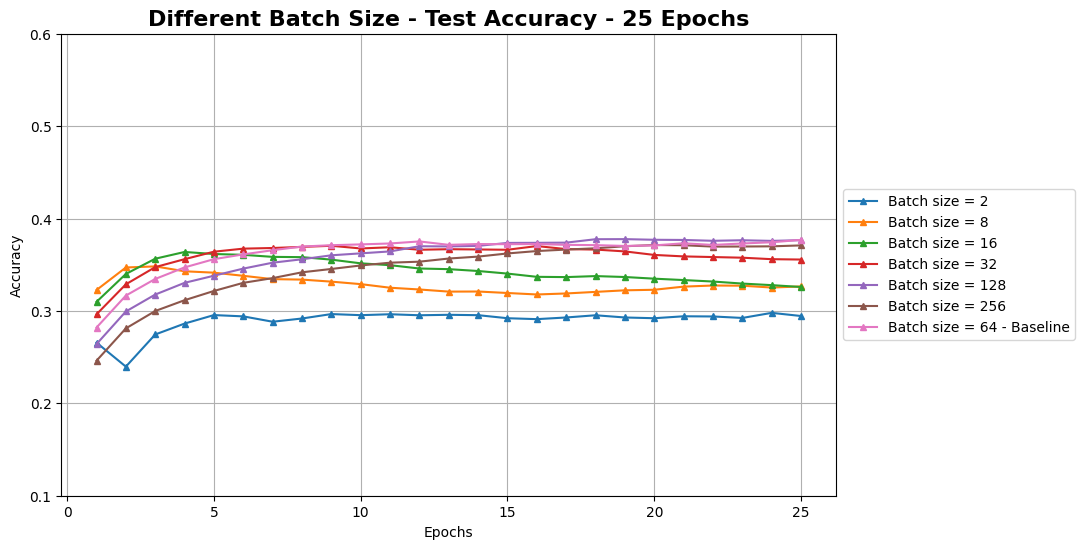

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

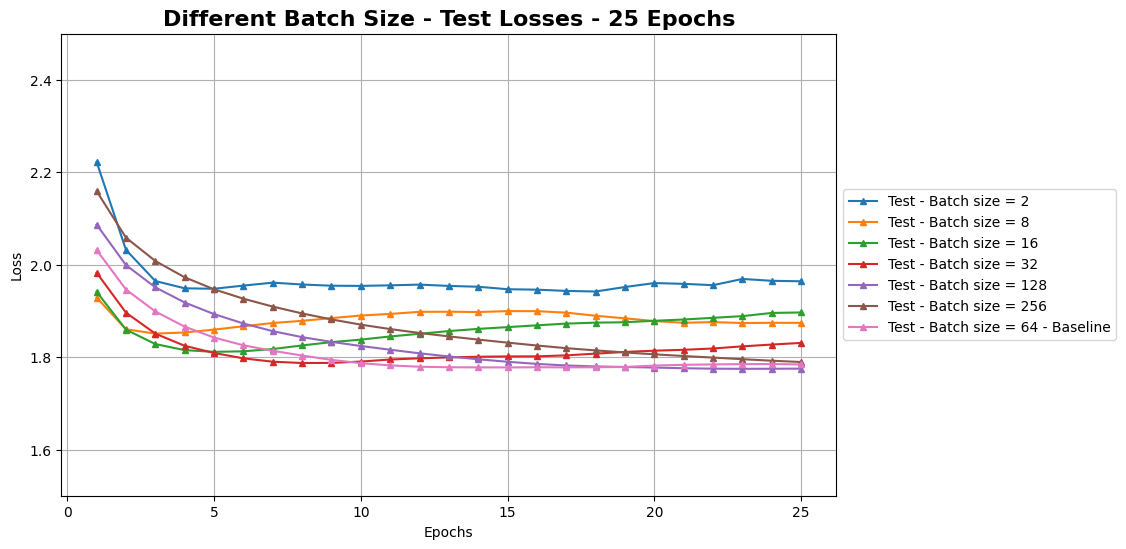

In [ ]:
for i in range(len(label_name_7)):
  plt.plot(range(1, len(validation_accuracies_7[i]) + 1), validation_accuracies_7[i], label=label_name_7[i], marker='^', markersize=5)
# for i in range(len(label_name_7)):
#   plt.plot(range(1, len(training_accuracies_7[i]) + 1), training_accuracies_7[i], label='Training - '+label_name_7[i], marker='s', markersize=3)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Different Batch Size - Test Accuracy - 25 Epochs', fontsize=16, fontweight='bold')
plt.gcf().set_size_inches(10, 6)
plt.ylim([0.1, 0.6])

# plt.savefig('Different Batch Size - Test Accuracy curves.jpg', bbox_inches='tight', dpi=300)
plt.savefig('Different Batch Size - Test Accuracy.jpg', bbox_inches='tight', dpi=300)
files.download('Different Batch Size - Test Accuracy.jpg')
plt.show()

for i in range(len(label_name_7)):
  plt.plot(range(1, len(validation_losses_7[i]) + 1), validation_losses_7[i], label='Test - '+label_name_7[i], marker='^', markersize=5)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Different Batch Size - Test Losses - 25 Epochs', fontsize=16, fontweight='bold')
plt.gcf().set_size_inches(10, 6)
plt.ylim([1.5, 2.5])

# plt.savefig('Different Batch Size - Losses curves.jpg', bbox_inches='tight', dpi=300)
plt.savefig('Different Batch Size - Losses curves.jpg', bbox_inches='tight', dpi=300)
files.download('Different Batch Size - Losses curves.jpg')
plt.show()

## 9 Best Model with different Batch size and learning rate

In [ ]:
batch_size_list = [2,16,64,128]
learning_rate_list = [0.0001,0.001]
label_name_9 = []
for i in range(len(batch_size_list)):
    for j in range(len(learning_rate_list)):
        label_name_9.append(('Batch size = ' + str(batch_size_list[i]),'Learning Rate= ' + str(learning_rate_list[j])))
print(label_name_9)

[('Batch size = 2', 'Learning Rate= 0.0001'), ('Batch size = 2', 'Learning Rate= 0.001'), ('Batch size = 16', 'Learning Rate= 0.0001'), ('Batch size = 16', 'Learning Rate= 0.001'), ('Batch size = 64', 'Learning Rate= 0.0001'), ('Batch size = 64', 'Learning Rate= 0.001'), ('Batch size = 128', 'Learning Rate= 0.0001'), ('Batch size = 128', 'Learning Rate= 0.001')]


In [ ]:
training_accuracies_9 = []
validation_accuracies_9 = []
training_losses_9 = []
validation_losses_9 = []

for bs in batch_size_list:
  for lr in learning_rate_list:
    print('Batch size ',str(bs),' and learning rate ',str(lr))
    nn9 = MLP([n_features, 512, n_class], [None, 'leaky_relu', None], optimizer = 'Adam', dropout=0, bn=True)
    model, training_accuracies, validation_accuracies, training_losses, validation_losses= nn9.fit(data_train,
                                                                                                label_train, 
                                                                                                learning_rate=lr, 
                                                                                                epochs=25, 
                                                                                                bs=bs,
                                                                                                data_val=data_test, 
                                                                                                label_val=label_test, 
                                                                                                momentum=0,
                                                                                                weight_decay=0.01)
    training_accuracies_9.append(training_accuracies)
    validation_accuracies_9.append(validation_accuracies)
    training_losses_9.append(training_losses)
    validation_losses_9.append(validation_losses)

In [ ]:
import pandas as pd
evaluation_metrics_table_9 = pd.concat([pd.DataFrame(np.transpose(np.vstack(training_accuracies_9)),columns = ['training_accuracies ' + str(i) for i in label_name_9]),
          pd.DataFrame(np.transpose(np.vstack(validation_accuracies_9)),columns = ['validation_accuracies ' + str(i) for i in label_name_9]),
          pd.DataFrame(np.transpose(np.vstack(training_losses_9)),columns = ['training_losses ' + str(i) for i in label_name_9]),
          pd.DataFrame(np.transpose(np.vstack(validation_losses_9)),columns = ['validation_losses ' + str(i) for i in label_name_9])
          ],axis=1)
evaluation_metrics_table_9

In [ ]:
evaluation_metrics_table_9_2 = pd.concat([pd.DataFrame(np.transpose(np.vstack(training_accuracies_9)),columns = ['training_accuracies ' + str(i) for i in label_name_9]),
          pd.DataFrame(np.transpose(np.vstack(validation_accuracies_9)),columns = ['validation_accuracies ' + str(i) for i in label_name_9])
          # pd.DataFrame(np.transpose(np.vstack(training_losses_9)),columns = ['training_losses ' + str(i) for i in label_name_9]),
          # pd.DataFrame(np.transpose(np.vstack(validation_losses_9)),columns = ['validation_losses ' + str(i) for i in label_name_9])
          ],axis=1)
evaluation_metrics_table_9_2

### Compare

In [ ]:
# color_list = ['g','b','r','c','y','k','#7f7f7f','#17becf']

color_list = ['g','g','b','b','r','r','c','c']
linestyle_list = ['solid','dashed'] * 4 


In [ ]:
for i in range(len(label_name_9)):
  plt.plot(range(1, len(validation_accuracies_9[i]) + 1), validation_accuracies_9[i], label=('Test:',label_name_9[i]), linestyle = linestyle_list[i],color = color_list[i]) #, marker='^', markersize=5
# for i in range(len(label_name_9)):
#   plt.plot(range(1, len(training_accuracies_9[i]) + 1), training_accuracies_9[i], label=('Train:',label_name_9[i]), linestyle='dashed', color = color_list[i])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Different Batch Size & Learning Rate - Test Accuracy - 25 Epochs', fontsize=16, fontweight='bold')
plt.gcf().set_size_inches(10, 6)
# plt.ylim([0.1, 0.6])

plt.savefig('Best Model Design: Batch Size and Learning Rate - Test Accuracy.jpg', bbox_inches='tight', dpi=300)
files.download('Best Model Design: Batch Size and Learning Rate - Test Accuracy.jpg')
plt.show()

for i in range(len(label_name_9)):
  plt.plot(range(1, len(validation_losses_9[i]) + 1), validation_losses_9[i], label=label_name_9[i], marker='^', markersize=5) #, color = color_list[i]

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Different Batch Size & Learning Rate - Test Losses - 25 Epochs', fontsize=16, fontweight='bold')
plt.gcf().set_size_inches(10, 6)
# plt.ylim([1.5, 2.5])

# plt.savefig('Different Batch Size and Learning Rate- Losses curves.jpg', bbox_inches='tight', dpi=300)
# files.download('Different Batch Size and Learning Rate- Losses curves.jpg')
plt.show()